In [23]:
# Data from here:
# https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from adjustText import adjust_text
from matplotlib.ticker import ScalarFormatter
import warnings
warnings.filterwarnings('ignore')

# READ CUMULATIVE TABLE
covid_cumulative = pd.read_excel("covid_a_master_cumulative_table.xlsx")

## FILTER THE LAST DAY OF THE RESULTS AND PICK THE TOP N IN # OF CASES

In [24]:
# This part is necessary instead of simply ['Date'].max() because some countries do not report on certain days (e.g. Spain on Sundays) -- FIXED BUG
last_day_per_country = covid_cumulative.groupby(by=['Countries'])['Date'].max() # type(last_day_per_country) is pandas.Series
last_day_per_country = last_day_per_country.to_frame() # We convert it to pandas.DataFrame
last_day_per_country.reset_index(inplace=True) # And reset the index so that we can further join on 'Countries'

In [25]:
# N: HOW MANY TOP COUNTRIES YOU WANT TO PICK IN TERMS OF # OF CASES
N = 25
last_day = pd.merge(covid_cumulative, last_day_per_country, how='inner', left_on = ['Countries', 'Date'], right_on = ['Countries', 'Date'])
last_day = last_day.sort_values('Cases', ascending=False)
last_day
top_countries = last_day[:N]['Countries'].tolist()
top_countries

['USA',
 'Brazil',
 'India',
 'Russia',
 'S.Africa',
 'Peru',
 'Mexico',
 'Colombia',
 'Spain',
 'Chile',
 'Argentina',
 'Iran',
 'UK',
 'S.Arabia',
 'Bangladesh',
 'Pakistan',
 'Italy',
 'Turkey',
 'France',
 'Germany',
 'Iraq',
 'Philippines',
 'Indonesia',
 'Kazakhstan',
 'Canada']

## FURTHER FILTER THE TOP N COUNTRIES WITH >K CASES


In [26]:
# K: HOW MANY CASES YOU CONSIDER THE DAY 0
K = 100
covid_top_countries = covid_cumulative[covid_cumulative.Countries.isin(top_countries)]
covid_top_countries = covid_top_countries[covid_top_countries['Cases'] > K]
# covid_top_countries

In [27]:
# FIND THE DATE THAT THE FIRST K CASES WERE IDENTIFIED
day_0_for_every_country = covid_top_countries.groupby(by=['Countries']).min()
day_0_for_every_country = day_0_for_every_country['Date']

In [28]:
# MERGE THE TWO TO GET THE DAY_0 IN THE df, AND CALCULATE THE DAYS_FROM_0
covid_top_countries = covid_top_countries.merge(day_0_for_every_country, how='inner', on='Countries')
covid_top_countries.rename(columns = {'Date_y': 'Day_0'}, inplace = True)
covid_top_countries['Days_from_0'] = (covid_top_countries['Date_x'] - covid_top_countries['Day_0']).dt.days
# covid_top_countries = covid_top_countries[covid_top_countries['Days_from_0']<150]
covid_top_countries

,Unnamed: 0,Cases,Deaths,Date_x,Countries,Population,Continent,Day_0,Days_from_0
0,3718,132,2,2020-02-24,Italy,60359546.0,Europe,2020-02-24,0
1,3785,229,6,2020-02-25,Italy,60359546.0,Europe,2020-02-24,1
2,3852,322,11,2020-02-26,Italy,60359546.0,Europe,2020-02-24,2
3,3919,400,12,2020-02-27,Italy,60359546.0,Europe,2020-02-24,3
4,3986,650,17,2020-02-28,Italy,60359546.0,Europe,2020-02-24,4
...,...,...,...,...,...,...,...,...,...
4176,37882,292625,3907,2020-08-23,Bangladesh,163046173.0,Asia,2020-04-07,138
4177,38091,294598,3941,2020-08-24,Bangladesh,163046173.0,Asia,2020-04-07,139
4178,38300,297083,3983,2020-08-25,Bangladesh,163046173.0,Asia,2020-04-07,140
4179,38509,299628,4028,2020-08-26,Bangladesh,163046173.0,Asia,2020-04-07,141


### CREATE THE MAX_CASES DF TO USE IT IN LABELING THE GRAPHS

In [29]:
max_cases = covid_top_countries.groupby(by=['Countries']).max()
max_cases['Case_fatality_rate'] = max_cases['Deaths']/max_cases['Cases']*100
max_cases.sort_values('Cases', ascending=False)
max_cases['Infection_rate_per_1m'] = max_cases['Cases']/max_cases['Population']*1000000
max_cases['Mortality_rate_per_1m'] = max_cases['Deaths']/max_cases['Population']*1000000
max_cases.drop('Unnamed: 0', axis = 1, inplace = True)
max_cases.to_excel('covid_b_max_cases.xlsx')

### Create the data to plot the dashed lines of doubling slopes: 1, 2, 3, 7 days. Formula for doubling: \\(K*2^{(days)}\\)

In [30]:
# FUNCTION THAT GIVES YOU THE DOUBLING SLOPE OF 1, 2, 3, 7 DAYS
x1 = np.array([0, 15])
x2 = np.array([0, 30])
x3 = np.array([0, 45])
x7 = np.array([0, 105])

y_1 = np.array([K, K*2**(x1[1])])
y_2 = np.array([K, K*2**(x2[1]/2)])
y_3 = np.array([K, K*2**(x3[1]/3)])
y_7 = np.array([K, K*2**(x7[1]/7)])

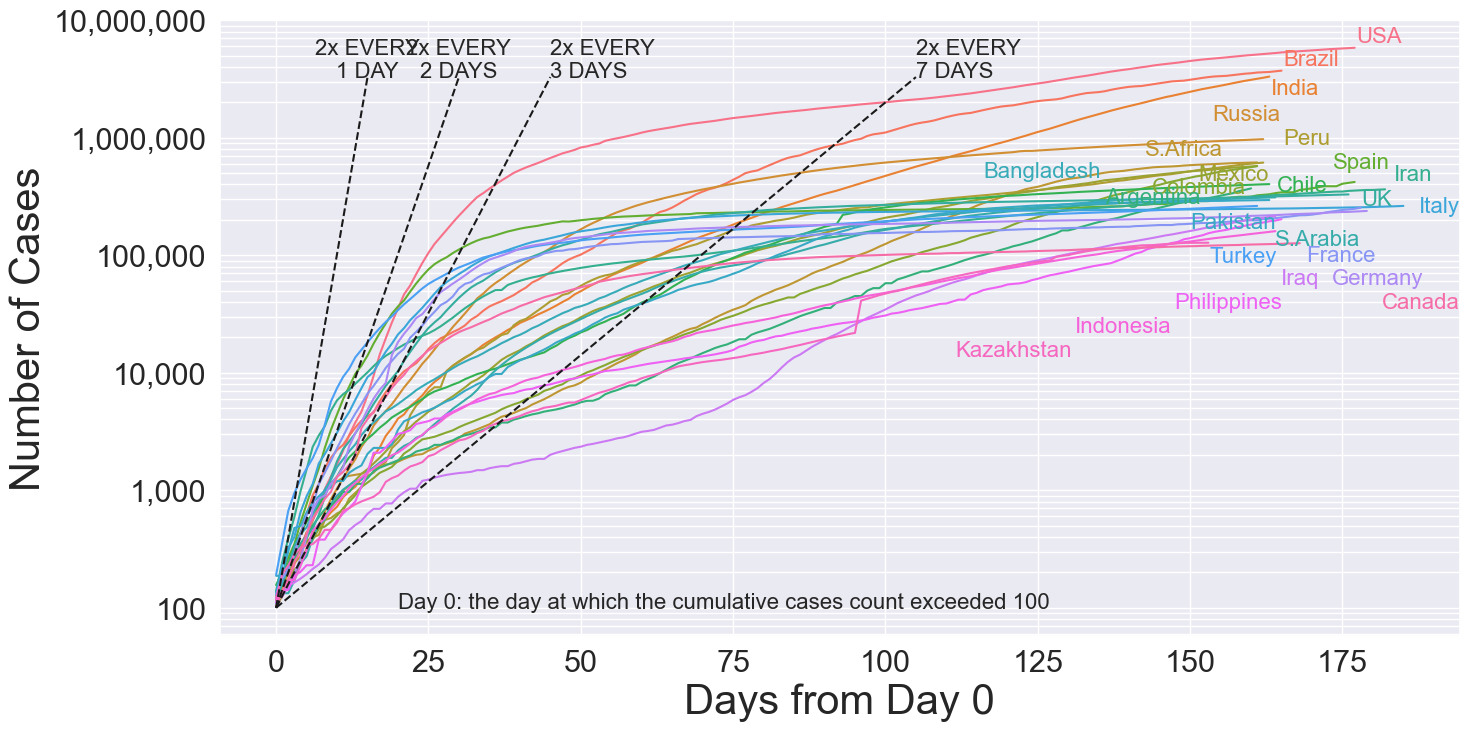

In [31]:
sns.set(rc={'figure.figsize':(16,8)}, font_scale = 2)
style = dict(size=10, color='gray')

ax = sns.lineplot(x="Days_from_0", y="Cases", hue="Countries", data=covid_top_countries, markers=True, hue_order=top_countries, legend=False)
ax.set_yscale('log')
plt.grid(True, which='both')
ax.plot(x1, y_1, 'k--')
ax.plot(x2, y_2, 'k--')
ax.plot(x3, y_3, 'k--')
ax.plot(x7, y_7, 'k--')
ax.set_xlabel("Days from Day 0",fontsize=30)
ax.set_ylabel("Number of Cases",fontsize=30)
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
# plt.xlim([0, 150])
plt.text(20, 100, 'Day 0: the day at which the cumulative cases count exceeded {:.0f}'.format(K), fontsize=16)
plt.text(x1.max(), y_1.max(), '2x EVERY\n1 DAY', ha = 'center', fontsize=16)
plt.text(x2.max(), y_2.max(), '2x EVERY\n2 DAYS', ha = 'center', fontsize=16)
plt.text(x3.max(), y_3.max(), '2x EVERY\n3 DAYS', ha = 'left', fontsize=16)
plt.text(x7.max(), y_7.max(), '2x EVERY\n7 DAYS', ha = 'left', fontsize=16)
texts = [plt.text(max_cases.loc[str(country)]['Days_from_0'], max_cases.loc[str(country)]['Cases'], str(country), fontsize=16, color=ax.get_lines()[top_countries.index(country)].get_c(), ha = 'center', va = 'center') for country in top_countries]
adjust_text(texts)

plt.savefig('covid_b_cases_daily.png')

In [32]:
Average_infection_rate_per_1m = max_cases['Cases'].sum()/max_cases['Population'].sum()*1000000
print("The average infection rate is: {:.1f} per 1m people".format(Average_infection_rate_per_1m))
Average_death_rate_per_1m = max_cases['Deaths'].sum()/max_cases['Population'].sum()*1000000
print("The average death rate is: {:.1f} per 1m people".format(Average_death_rate_per_1m))
Average_mortality_per_cent_infected = max_cases['Deaths'].sum()/max_cases['Cases'].sum()*100
print("The average mortality rate is: {:.1f} per 100 people infected".format(Average_mortality_per_cent_infected))

The average infection rate is: 5538.8 per 1m people
The average death rate is: 194.0 per 1m people
The average mortality rate is: 3.5 per 100 people infected


## CALCULATE THE RATE OF CHANGE

In [33]:
# back_calc IS THE BACK WINDOW THAT IS USED TO CALCULATE THE SLOPE
back_calc = 7
slope_df = pd.DataFrame(columns=['Countries', 'Days_from_0', 'Slope', 'R2', 'P_value'])

for country in top_countries:
    one_country_data = covid_top_countries[covid_top_countries['Countries'] == str(country)].reset_index(drop=True)
#     one_country_data['log_cases'] = np.log10(one_country_data['Cases'])
    for i in np.arange(back_calc, len(one_country_data)+1):
        x = one_country_data.loc[i-back_calc: i, 'Days_from_0'] # That is the 'Days_from_0'
        y = one_country_data.loc[i-back_calc: i, 'Cases'] # 
        slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        one_country_data.loc[i-1, 'Slope'] = slope
        one_country_data.loc[i-1, 'R2'] = r_value * r_value
        one_country_data.loc[i-1, 'P_value'] = p_value
        one_country = one_country_data[['Countries', 'Days_from_0', 'Slope', 'R2', 'P_value']]
    
    slope_df = slope_df.append(one_country, ignore_index=False)
    
slope_df.head(15)

,Countries,Days_from_0,Slope,R2,P_value
0,USA,0,NaN,NaN,NaN
1,USA,1,NaN,NaN,NaN
2,USA,2,NaN,NaN,NaN
3,USA,3,NaN,NaN,NaN
4,USA,4,NaN,NaN,NaN
5,USA,5,NaN,NaN,NaN
6,USA,6,90.821429,0.930301,0.000109
7,USA,7,123.011905,0.929113,0.000114
8,USA,8,159.523810,0.938296,0.000075
9,USA,9,200.666667,0.945436,0.000052


In [34]:
slope_df.set_index('Countries', drop=True, inplace=True)
slope_df.to_excel('covid_b_slope_daily.xlsx')

In [44]:
slope_df.index.name = 'Countries'
print(slope_df)
max_slope = slope_df.groupby(by=['Countries']).max()
max_slope = max_slope.sort_values('Slope', ascending=False)
#max_slope['Countries'] = max_slope.index
print(max_slope)

data_1_5 = slope_df[slope_df.index.isin(max_slope[:5].index.tolist())]
countries_1_5 = max_slope[:5].index.tolist()
data_6_10 = slope_df[slope_df.index.isin(max_slope[5:10].index.tolist())]
countries_6_10 = max_slope[5:10].index.tolist()
data_11_15 = slope_df[slope_df.index.isin(max_slope[10:15].index.tolist())]
countries_11_15 = max_slope[10:15].index.tolist()
data_16_20 = slope_df[slope_df.index.isin(max_slope[15:20].index.tolist())]
countries_16_20 = max_slope[15:20].index.tolist()
max_slope

          Days_from_0       Slope        R2       P_value
Countries                                                
USA                 0         NaN       NaN           NaN
USA                 1         NaN       NaN           NaN
USA                 2         NaN       NaN           NaN
USA                 3         NaN       NaN           NaN
USA                 4         NaN       NaN           NaN
...               ...         ...       ...           ...
Canada            164  386.726190  0.981761  1.909315e-06
Canada            165  381.559524  0.985449  9.679942e-07
Canada            166  402.571429  0.988159  5.211786e-07
Canada            167  417.392857  0.989326  3.815292e-07
Canada            168  423.000000  0.984999  9.409006e-06

[4181 rows x 4 columns]
             Days_from_0         Slope        R2   P_value
Countries                                                 
USA                  177  68400.226190  0.999628  0.001072
India                163  67159.107143  0.99

,Days_from_0,Slope,R2,P_value
Countries,,,,
USA,177,68400.226190,0.999628,0.001072
India,163,67159.107143,0.999994,0.000396
Brazil,165,50420.785714,0.998226,0.000266
S.Africa,161,12665.083333,0.999572,0.001309
Colombia,161,11625.559524,0.999782,0.000035
Chile,163,11243.226190,0.999757,0.002052
Russia,162,10995.083333,0.999993,0.000149
Argentina,160,9711.392857,0.999450,0.000092
Peru,162,8689.214286,0.999823,0.000905


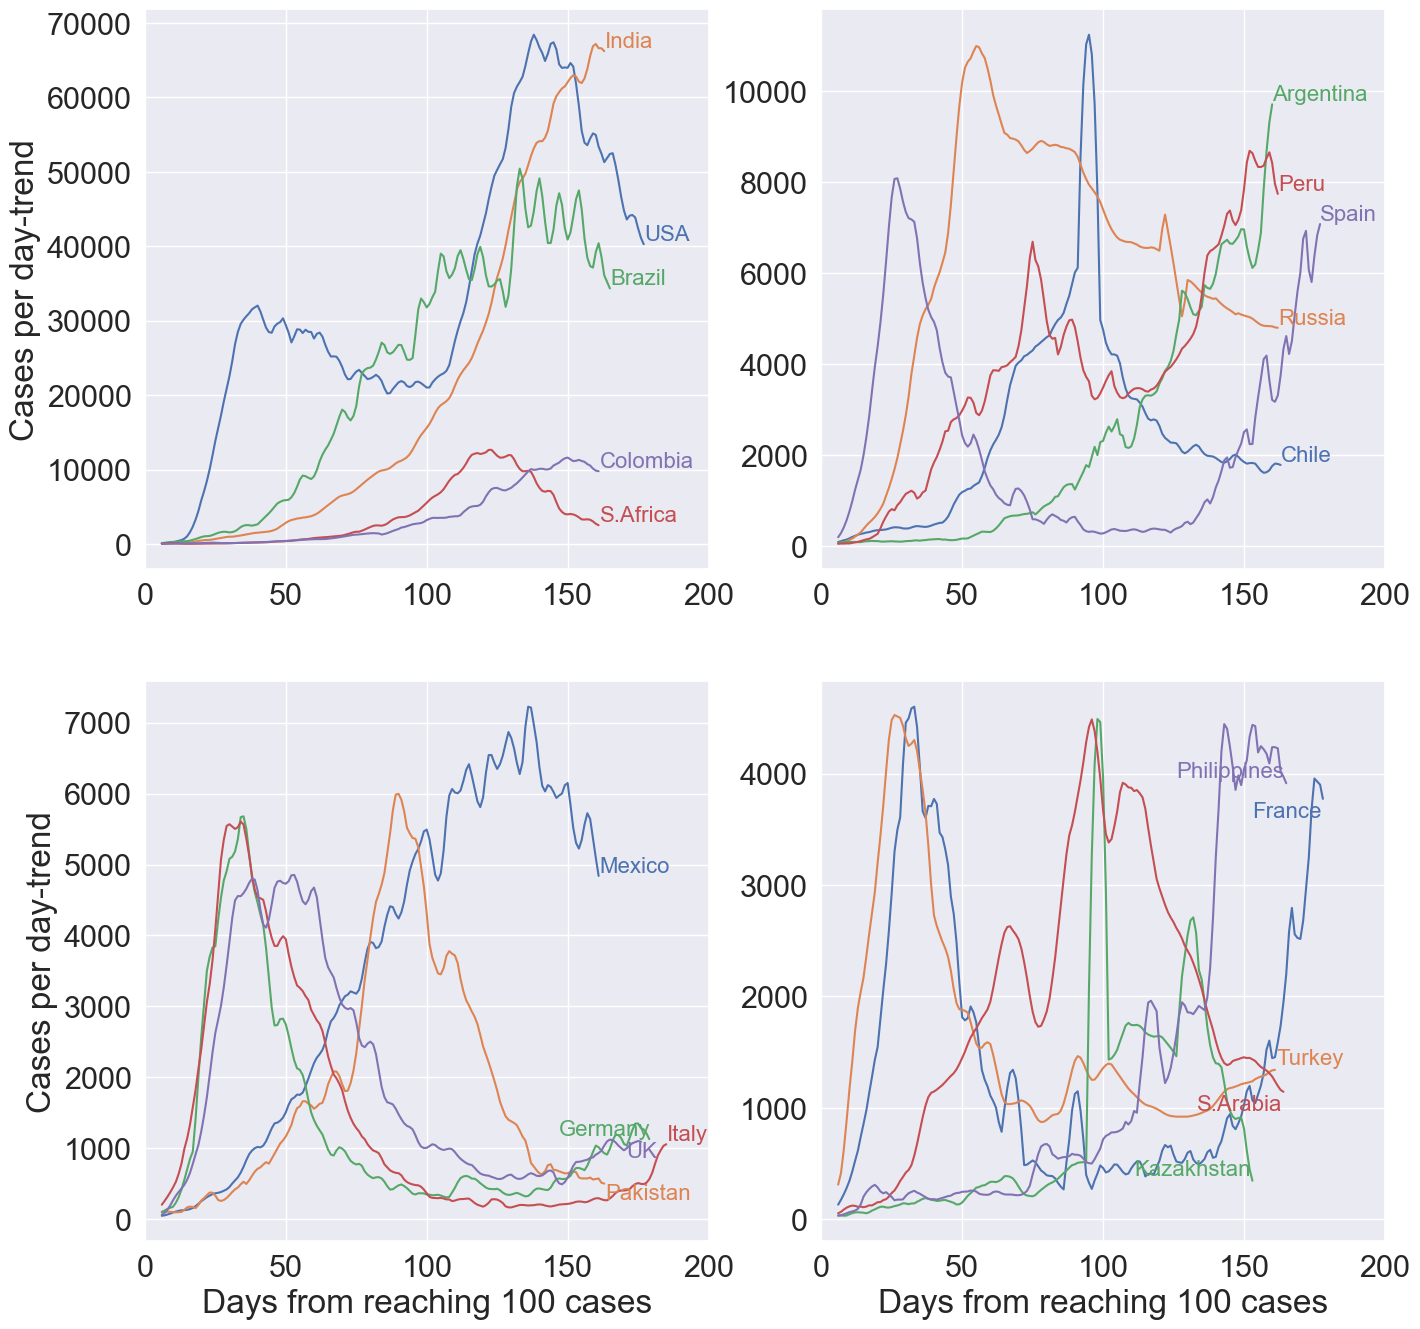

In [50]:
sns.set(rc={'figure.figsize':(16,16)}, font_scale = 2)
fig, axes = plt.subplots(2, 2)

data_1_5_idx = data_1_5.reset_index()
data_6_10_idx = data_6_10.reset_index()
data_11_15_idx = data_11_15.reset_index()
data_16_20_idx = data_16_20.reset_index()

sns.lineplot(x="Days_from_0", y="Slope", hue="Countries", data=data_1_5_idx, markers=True, hue_order=countries_1_5, legend=False, ax=axes[0, 0])
texts = [axes[0, 0].text(max_cases.loc[str(country)]['Days_from_0'], slope_df.loc[str(country)]['Slope'].iloc[-1], str(country), fontsize=16, color=axes[0, 0].get_lines()[countries_1_5.index(country)].get_c(), ha = 'left', va = 'center') for country in countries_1_5]
adjust_text(texts)
axes[0, 0].set_ylabel("Cases per day-trend",fontsize=24)

sns.lineplot(x="Days_from_0", y="Slope", hue="Countries", data=data_6_10_idx, markers=True, hue_order=countries_6_10, legend=False, ax=axes[0, 1])
texts = [axes[0, 1].text(max_cases.loc[str(country)]['Days_from_0'], slope_df.loc[str(country)]['Slope'].iloc[-1], str(country), fontsize=16, color=axes[0, 1].get_lines()[countries_6_10.index(country)].get_c(), ha = 'left', va = 'top') for country in countries_6_10]
adjust_text(texts)

sns.lineplot(x="Days_from_0", y="Slope", hue="Countries", data=data_11_15_idx, markers=True, hue_order=countries_11_15, legend=False, ax=axes[1, 0])
texts = [axes[1, 0].text(max_cases.loc[str(country)]['Days_from_0'], slope_df.loc[str(country)]['Slope'].iloc[-1], str(country), fontsize=16, color=axes[1, 0].get_lines()[countries_11_15.index(country)].get_c(), ha = 'left', va = 'center') for country in countries_11_15]
adjust_text(texts)
axes[1, 0].set_ylabel("Cases per day-trend",fontsize=24)
axes[1, 0].set_xlabel("Days from reaching 100 cases",fontsize=24)

sns.lineplot(x="Days_from_0", y="Slope", hue="Countries", data=data_16_20_idx, markers=True, hue_order=countries_16_20, legend=False, ax=axes[1, 1])
texts = [axes[1, 1].text(max_cases.loc[str(country)]['Days_from_0'], slope_df.loc[str(country)]['Slope'].iloc[-1], str(country), fontsize=16, color=axes[1, 1].get_lines()[countries_16_20.index(country)].get_c(), ha = 'left', va = 'center') for country in countries_16_20]
adjust_text(texts)
axes[1, 1].set_xlabel("Days from reaching 100 cases",fontsize=24)

axes[0, 1].set_ylabel("",fontsize=24)
axes[1, 1].set_ylabel("",fontsize=24)
axes[0, 0].set_xlabel("",fontsize=24)
axes[0, 1].set_xlabel("",fontsize=24)
axes[0, 1].set_xlim([0, 200])
axes[1, 1].set_xlim([0, 200])
axes[0, 0].set_xlim([0, 200])
axes[1, 0].set_xlim([0, 200])
# axes[0, 0].set_yscale('log')
# axes[0, 1].set_yscale('log')
# axes[1, 0].set_yscale('log')
# axes[1, 1].set_yscale('log')

plt.savefig('covid_b_Infection_rate_profile.png')